In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse
import math
import random
from matplotlib import cm

In [2]:
d = pd.read_csv('Chr20FuncIntx.tsv', sep='\t', header=0)

In [3]:
vertices = set(list(d['a']) + list(d['b']))
edges = [(r['a'], r['b']) for i, r in d.iterrows()]
weights = [r['score'] for i, r in d.iterrows()]

In [4]:
g = nx.Graph()
g.add_nodes_from(list(vertices))
g.add_edges_from(edges)

In [5]:
# TODO find a good community detection fcn
# TODO add edge weights?
communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))

In [6]:
layout = nx.spring_layout(g)

In [7]:
p = [None]*len(layout)
x = [None]*len(layout)
y = [None]*len(layout)

i = 0
for k, v in layout.items():
    p[i] = k
    x[i] = v[0]
    y[i] = v[1]
    i += 1
    
# TODO how to pick color palette?!
colors=[v for k, v in mcolors.CSS4_COLORS.items()]
colors=[colors[i*5] for i in range(len(communities))]

In [8]:
xy_centers = np.ones((len(communities), 2))

for j, community in zip(range(len(communities)), communities):
    nproteins=len(community)
    p_x = [None]*nproteins
    p_y = [None]*nproteins
    
    for i, protein in zip(range(nproteins), community):
        p_x[i] = layout[protein][0]
        p_y[i] = layout[protein][1]
        
    p_x = np.array(p_x)
    p_y = np.array(p_y)
    
    x_rad = (np.max(p_x) - np.min(p_x))/2.0
    y_rad = (np.max(p_y) - np.min(p_y))/2.0
    xy_centers[j] = [x_rad+np.min(p_x), y_rad+np.min(p_y)]
    
xy_centers = xy_centers*100

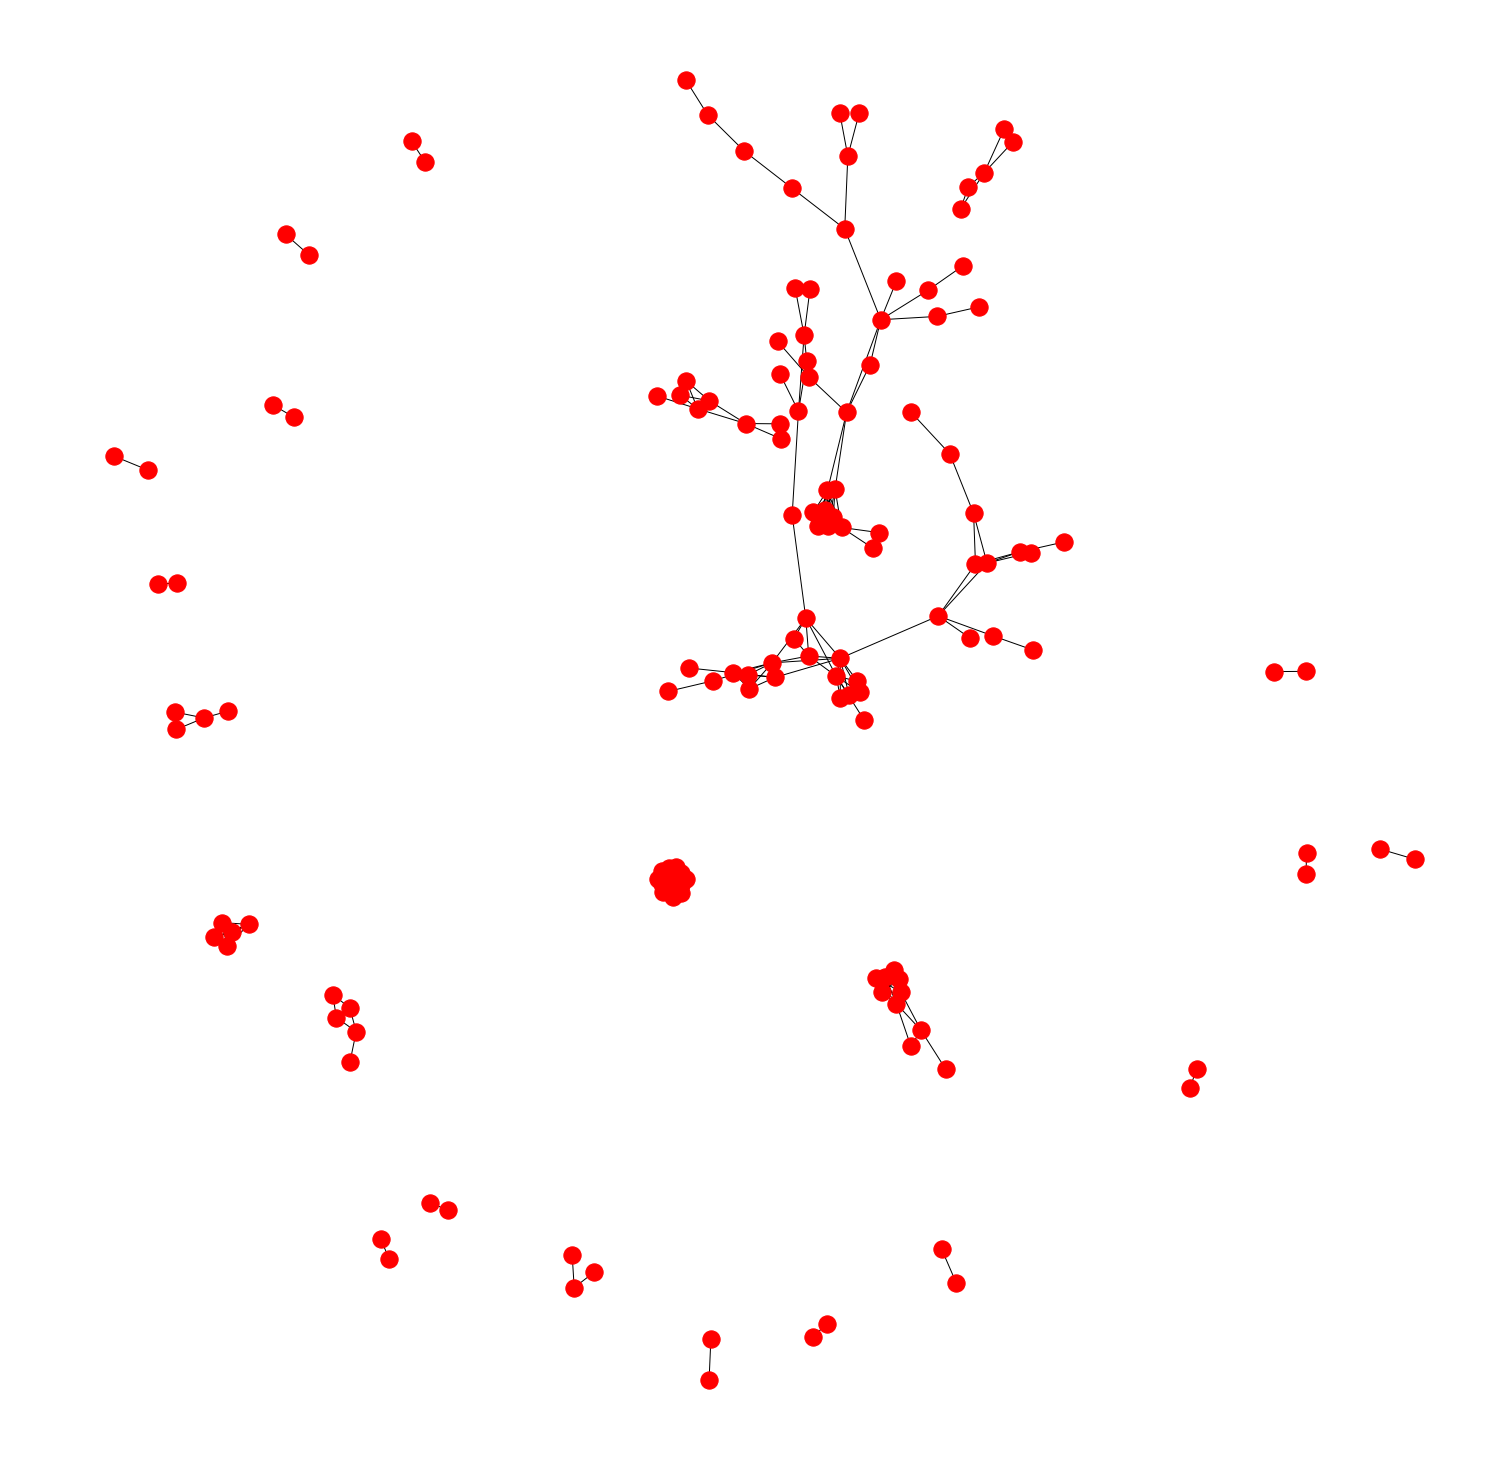

In [9]:
fig = plt.figure(figsize=(20, 20))
nx.draw(g, pos=layout)
plt.show()

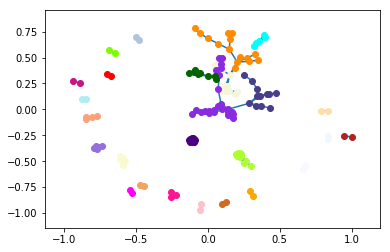

In [10]:
lines = [None]*len(edges)
for i, e in zip(range(len(edges)), edges):
    pos0 = layout[e[0]]
    pos1 = layout[e[1]]
    lines[i] = [(pos0[0], pos0[1]), (pos1[0], pos1[1])]
lc = mc.LineCollection(lines)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

for community, color in zip(communities, colors):
    for protein in community:
        pos = layout[protein]
        plt.plot(pos[0], pos[1], color=color, marker='o')
        
plt.show()

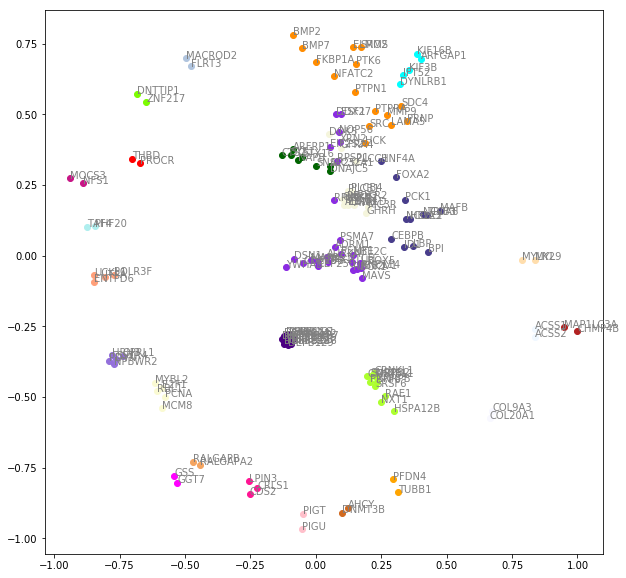

In [11]:
plt.figure(figsize=[10, 10])

for i in range(len(p)):
    plt.text(x[i], y[i], p[i], color='gray')

for community, color in zip(communities, colors):
    for protein in community:
        pos = layout[protein]
        plt.plot(pos[0], pos[1], color=color, marker='o')  

plt.show()

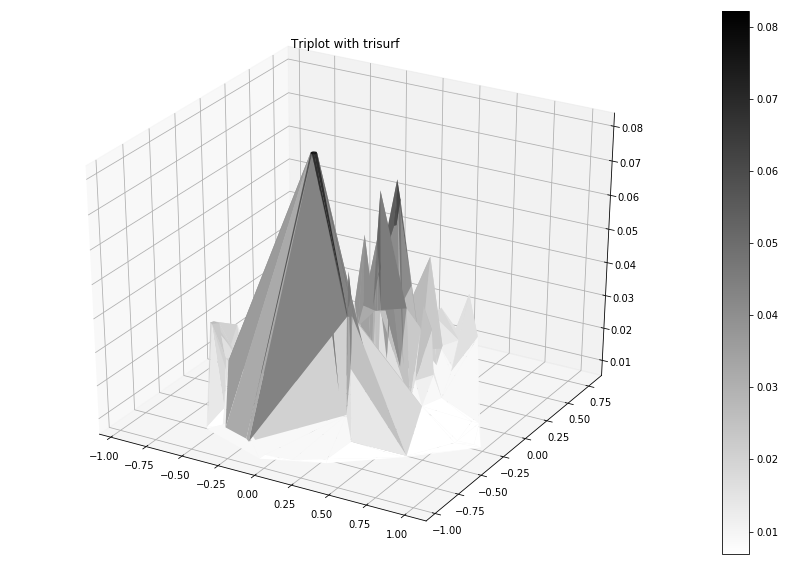

In [12]:
triang = mtri.Triangulation(x, y)

cen = nx.degree_centrality(g)
z = [None] * len(x)
for i in range(len(x)):
    z[i] = cen[p[i]]

fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(triang, z, linewidth=0.1, antialiased=True, cmap='gray_r', shade=True)
fig.colorbar(surf)
plt.title('Triplot with trisurf')
plt.show()

In [13]:
# https://stackoverflow.com/questions/39402109/generating-points-on-a-circle
def points_along_ellipse(x_radius, y_radius, x_center, y_center, inner_shift=0):
    x = []
    y = []
    if inner_shift >= min(x_radius, y_radius):
        print('ERROR: points_along_ellipse - inner_shift')
        return None
    for i in range(0,1000):
        angle = random.uniform(0,1)*(math.pi*2)
        x.append(x_center + (x_radius-inner_shift)*math.cos(angle));
        y.append(y_center + (y_radius-inner_shift)*math.sin(angle));
    return {'x': x, 'y': y}

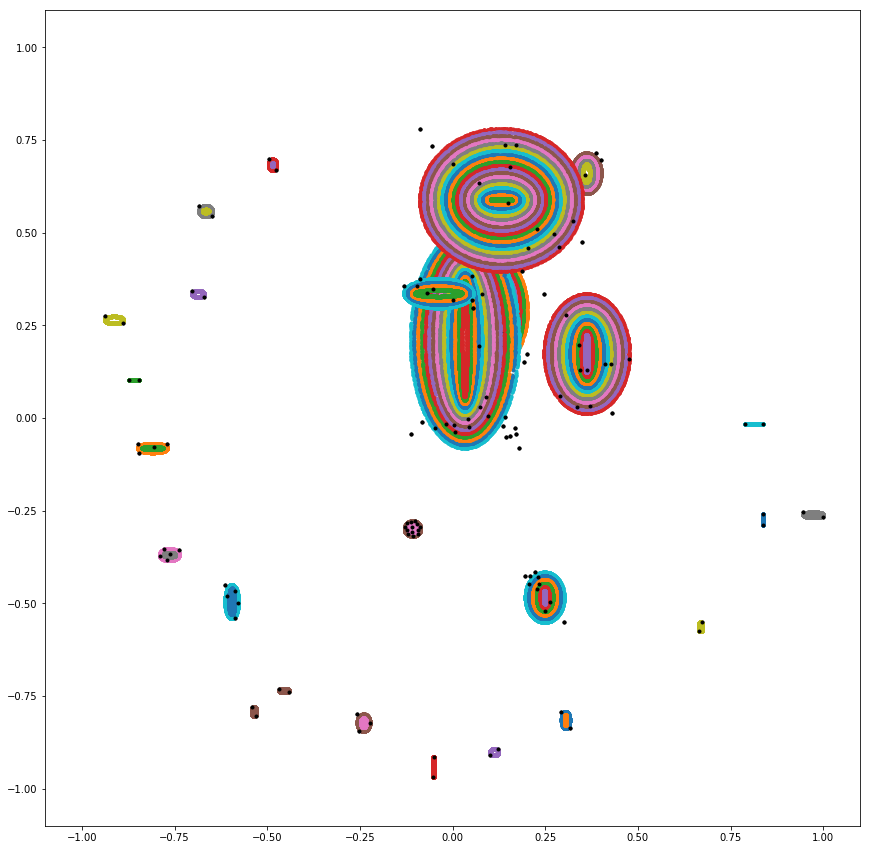

In [14]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=[15,15])

for community in communities:
    
    p_x = [None]*len(community)
    p_y = [None]*len(community)
    p_z = [None]*len(community)
    
    for i, protein in zip(range(len(community)), community):
        p_x[i] = layout[protein][0]
        p_y[i] = layout[protein][1]
        p_z[i] = cen[protein]
        pos = layout[protein]
        ax.plot(p_x[i], p_y[i], marker='.', color='k')
        
    p_x = np.array(p_x)
    p_y = np.array(p_y)
    p_z = np.array(p_z)
    
    x_rad = (np.max(p_x) - np.min(p_x))/2.0
    y_rad = (np.max(p_y) - np.min(p_y))/2.0
    center = [x_rad+np.min(p_x), y_rad+np.min(p_y)]
    
    for i in np.arange(0, max(0, min(x_rad, y_rad)), 0.01):
        ellipse = points_along_ellipse(x_radius=x_rad,
                                       y_radius=y_rad,
                                       x_center=center[0],
                                       y_center=center[1],
                                       inner_shift = i)
        ax.plot(ellipse['x'], ellipse['y'], '.')
        
    for i, protein in zip(range(len(community)), community):
        pos = layout[protein]
        ax.plot(p_x[i], p_y[i], marker='.', color='k')
    
    #e = Ellipse(xy=center, width=x_diam, height=y_diam, angle=180)
    #ax.add_artist(e)
    #e.set_clip_box(ax.bbox)
    #e.set_alpha(np.random.rand())
    #e.set_facecolor(np.random.rand(3))
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

plt.show()
                          

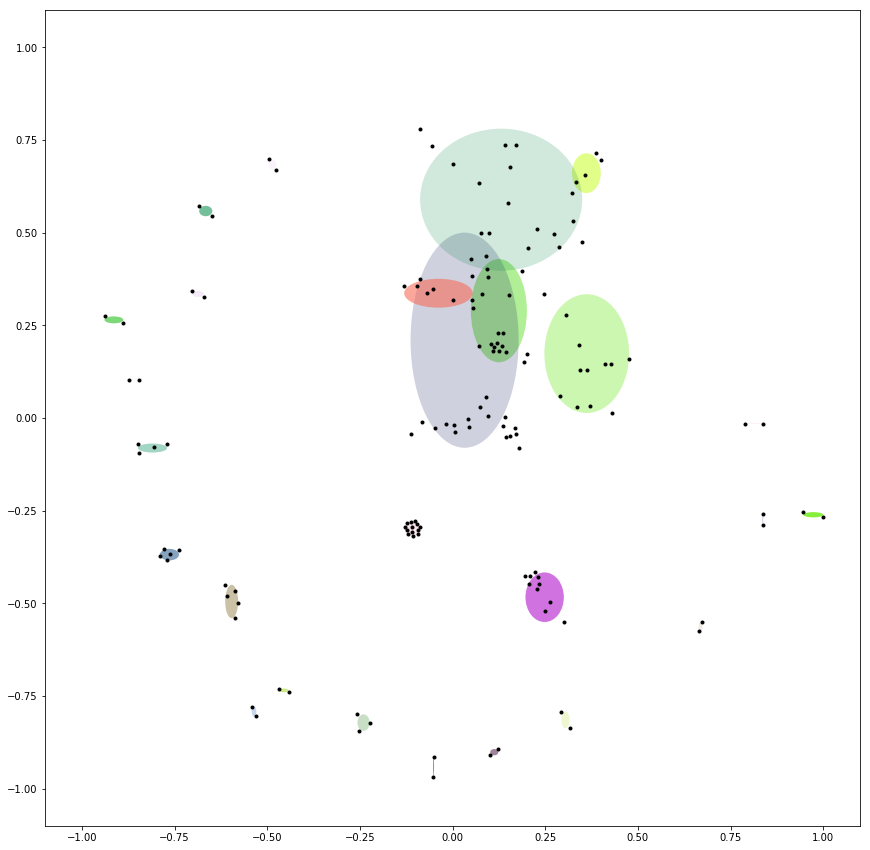

In [15]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=[15,15])

for community in communities:
    
    p_x = [None]*len(community)
    p_y = [None]*len(community)
    p_z = [None]*len(community)
    
    for i, protein in zip(range(len(community)), community):
        p_x[i] = layout[protein][0]
        p_y[i] = layout[protein][1]
        p_z[i] = cen[protein]
        pos = layout[protein]
        ax.plot(p_x[i], p_y[i], marker='.', color='k')
        
    p_x = np.array(p_x)
    p_y = np.array(p_y)
    p_z = np.array(p_z)
    
    x_rad = (np.max(p_x) - np.min(p_x))/2.0
    y_rad = (np.max(p_y) - np.min(p_y))/2.0
    center = [x_rad+np.min(p_x), y_rad+np.min(p_y)]
    
    e = Ellipse(xy=center, width=x_rad*2, height=y_rad*2, angle=180)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(np.random.rand())
    e.set_facecolor(np.random.rand(3))
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

plt.show()
                          

In [16]:
# https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

def multivariate_gaussian_XYZ(N, center, xy_score, z_score):
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Mean vector and covariance matrix
    mu = np.array([0., 1.])
    Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])
    
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    # scale to be in [-xy_score, xy_score]
    X = X * xy_score + center[0]
    Y = Y * xy_score + center[1]
    Z *= z_score
    
    return X, Y, Z

In [17]:
X, Y, Z = multivariate_gaussian_XYZ(N=60,
                                    center=(1,4),
                                    xy_score=1,
                                    z_score=2)


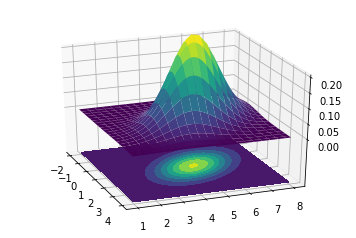

In [18]:
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

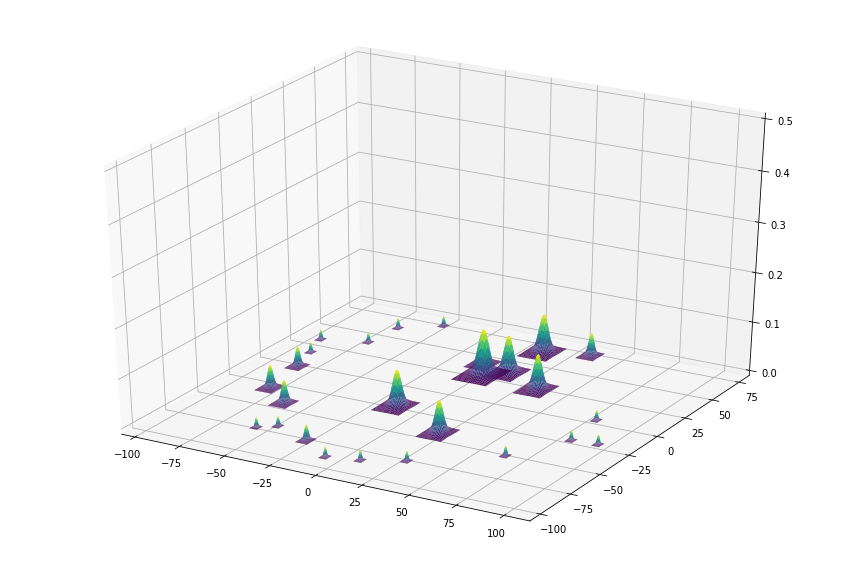

In [19]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')

for i in range(len(communities)):
    community = communities[i]
    center = xy_centers[i]
    
    nproteins = len(community)
    ngo = nproteins #TODO
    
    X,Y,Z = multivariate_gaussian_XYZ(N=60,
                                      center=center,
                                      xy_score=math.log(nproteins),
                                      z_score=math.log(nproteins)/5)
    
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(0,0.5)
plt.show()

In [20]:
point  = np.array([-100, 100, 0])
normal = np.array([0, 0, 1])
point2 = np.array([0, 0, 0])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(-110, 110), range(-110, 110))

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

# plot the surface
ax.plot_surface(xx, yy, z, cmap=cm.viridis, alpha=0.2)